<a href="https://www.kaggle.com/code/cemkesici/melbourne-housing-market?scriptVersionId=147617771" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df= pd.read_csv("/kaggle/input/melbourne-housing-market/Melbourne_housing_FULL.csv")

In [4]:
def check_dataframe(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Duplicated #####################")
    print(dataframe.duplicated().sum())
    print("##################### Describe #####################")
    print(dataframe.describe().T)

In [5]:
check_dataframe(df)

##################### Shape #####################
(34857, 21)
##################### Types #####################
Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object
##################### Head #####################
       Suburb          Address  Rooms Type       Price Method SellerG  \
0  Abbotsford    68 Studley St      2    h         NaN     SS  Jellis   
1  Abbotsford     85 Turner St      2    h 1480000.000      S  Biggin   
2  Abbotsford  25 Bloomburg St      2    h 1035000.000      S  Biggin   

       

In [6]:
columns_to_drop = ["Lattitude","Longtitude"]
df = df.drop(columns_to_drop, axis=1)
check_dataframe(df)

##################### Shape #####################
(34857, 19)
##################### Types #####################
Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Regionname        object
Propertycount    float64
dtype: object
##################### Head #####################
       Suburb          Address  Rooms Type       Price Method SellerG  \
0  Abbotsford    68 Studley St      2    h         NaN     SS  Jellis   
1  Abbotsford     85 Turner St      2    h 1480000.000      S  Biggin   
2  Abbotsford  25 Bloomburg St      2    h 1035000.000      S  Biggin   

        Date  Distance  Postcode  Bedroom2  Bathroom   Ca

In [7]:
def grab_col_names(df, cat_th=7, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations(Rows): {df.shape[0]}")
    print(f"Variables(Columns): {df.shape[1]}\n")
    print(f'cat_cols: {len(cat_cols)}\nnum_cols: {len(num_cols)}\ncat_but_car: {len(cat_but_car)}\nnum_but_cat: {len(num_but_cat)}')
    print(f"\ncat_cols: {cat_cols}\nnum_cols: {num_cols}\ncat_but_car: {cat_but_car}\n")

    print(f"\ncat_cols data types:\n\n{df[cat_cols].dtypes}\n\nnum_cols data types:\n\n{df[num_cols].dtypes}\n\ncat_but_car data types:\n\n{df[cat_but_car].dtypes}")

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations(Rows): 34857
Variables(Columns): 19

cat_cols: 3
num_cols: 11
cat_but_car: 5
num_but_cat: 0

cat_cols: ['Type', 'Method', 'Regionname']
num_cols: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type          object
Method        object
Regionname    object
dtype: object

num_cols data types:

Rooms              int64
Price            float64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object


In [8]:
######################################
# Kategorik Değişken Analizi (Analysis of Categorical Variables)
######################################

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

       Type  Ratio
Type              
h     23980 68.795
u      7297 20.934
t      3580 10.271
        Method  Ratio
Method               
S        19744 56.643
SP        5095 14.617
PI        4850 13.914
VB        3108  8.916
SN        1317  3.778
PN         308  0.884
SA         226  0.648
W          173  0.496
SS          36  0.103
                            Regionname  Ratio
Regionname                                   
Southern Metropolitan            11836 33.956
Northern Metropolitan             9557 27.418
Western Metropolitan              6799 19.505
Eastern Metropolitan              4377 12.557
South-Eastern Metropolitan        1739  4.989
Eastern Victoria                   228  0.654
Northern Victoria                  203  0.582
Western Victoria                   115  0.330


count   34857.000
mean        3.031
std         0.970
min         1.000
5%          2.000
10%         2.000
20%         2.000
30%         3.000
40%         3.000
50%         3.000
60%         3.000
70%         3.000
80%         4.000
90%         4.000
95%         5.000
99%         5.000
max        16.000
Name: Rooms, dtype: float64


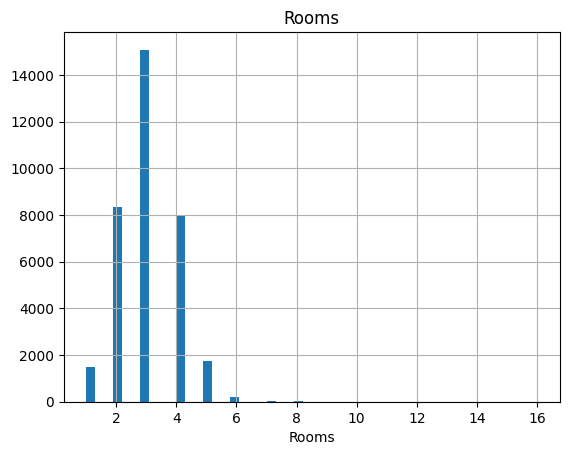

#####################################
count      27247.000
mean     1050173.345
std       641467.130
min        85000.000
5%        415000.000
10%       485300.000
20%       594600.000
30%       678000.000
40%       770000.000
50%       870000.000
60%      1000000.000
70%      1200000.000
80%      1400000.000
90%      1800000.000
95%      2250000.000
99%      3400540.000
max     11200000.000
Name: Price, dtype: float64


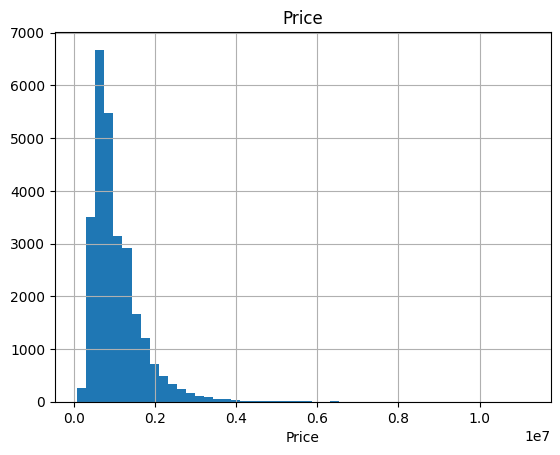

#####################################
count   34856.000
mean       11.185
std         6.789
min         0.000
5%          2.700
10%         3.800
20%         5.600
30%         7.300
40%         8.500
50%        10.300
60%        11.400
70%        13.400
80%        14.800
90%        19.900
95%        24.700
99%        35.400
max        48.100
Name: Distance, dtype: float64


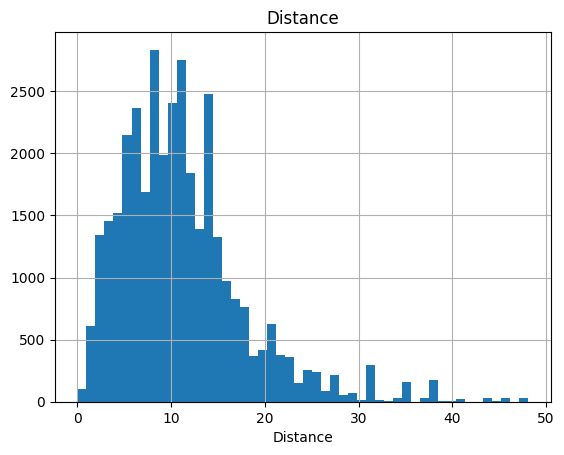

#####################################
count   34856.000
mean     3116.063
std       109.024
min      3000.000
5%       3015.000
10%      3024.000
20%      3042.000
30%      3058.000
40%      3073.000
50%      3103.000
60%      3125.000
70%      3146.000
80%      3168.000
90%      3190.000
95%      3204.000
99%      3754.000
max      3978.000
Name: Postcode, dtype: float64


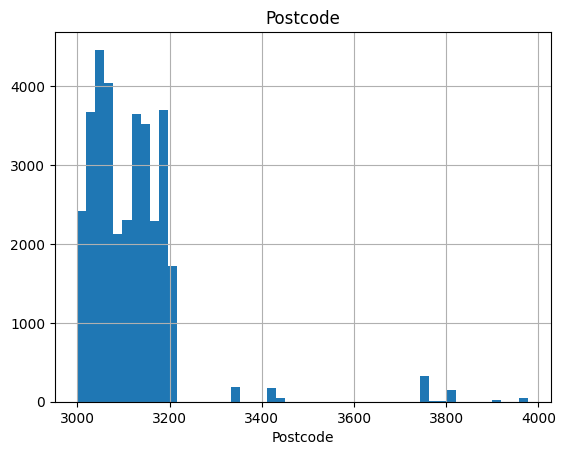

#####################################
count   26640.000
mean        3.085
std         0.981
min         0.000
5%          2.000
10%         2.000
20%         2.000
30%         3.000
40%         3.000
50%         3.000
60%         3.000
70%         4.000
80%         4.000
90%         4.000
95%         5.000
99%         5.000
max        30.000
Name: Bedroom2, dtype: float64


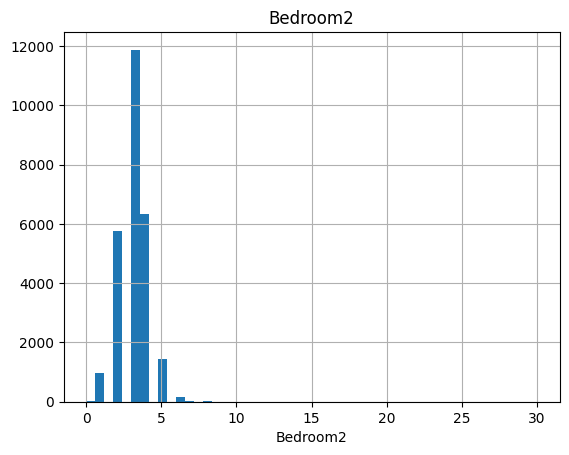

#####################################
count   26631.000
mean        1.625
std         0.724
min         0.000
5%          1.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         2.000
60%         2.000
70%         2.000
80%         2.000
90%         2.000
95%         3.000
99%         4.000
max        12.000
Name: Bathroom, dtype: float64


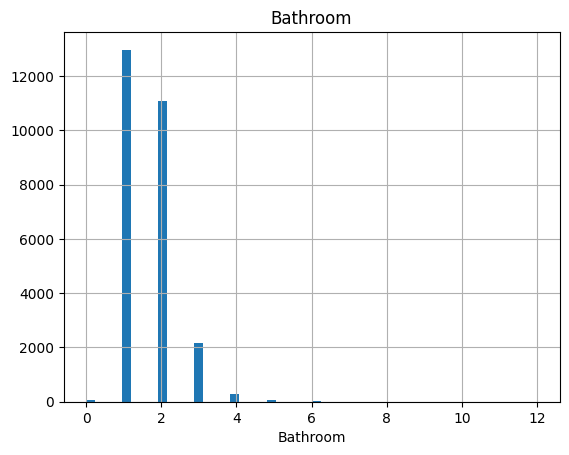

#####################################
count   26129.000
mean        1.729
std         1.011
min         0.000
5%          0.000
10%         1.000
20%         1.000
30%         1.000
40%         1.000
50%         2.000
60%         2.000
70%         2.000
80%         2.000
90%         3.000
95%         4.000
99%         5.000
max        26.000
Name: Car, dtype: float64


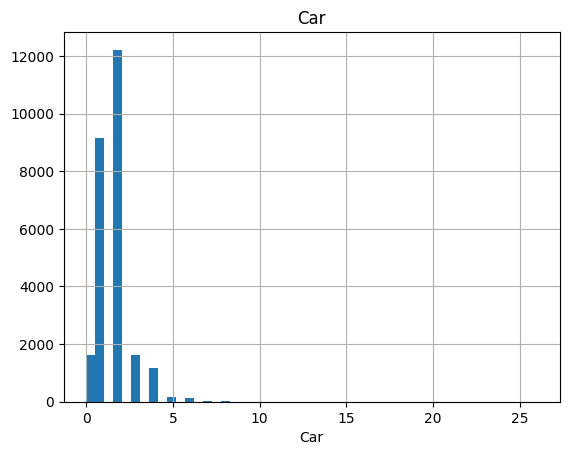

#####################################
count    23047.000
mean       593.599
std       3398.842
min          0.000
5%           0.000
10%          0.000
20%        179.000
30%        276.000
40%        385.000
50%        521.000
60%        587.000
70%        648.000
80%        702.000
90%        824.000
95%       1001.000
99%       2942.120
max     433014.000
Name: Landsize, dtype: float64


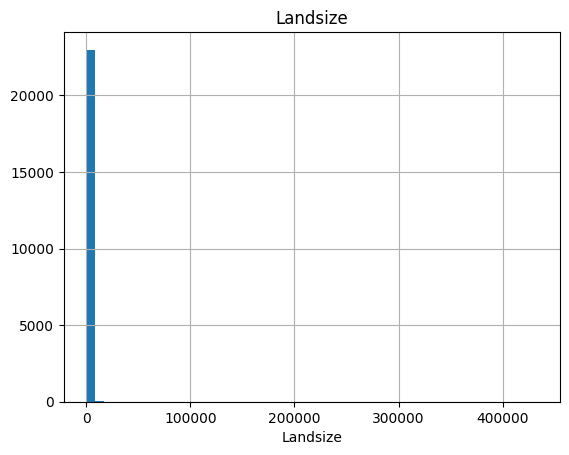

#####################################
count   13742.000
mean      160.256
std       401.267
min         0.000
5%         56.000
10%        73.000
20%        94.000
30%       109.000
40%       121.000
50%       136.000
60%       153.000
70%       175.000
80%       204.000
90%       258.000
95%       310.000
99%       473.180
max     44515.000
Name: BuildingArea, dtype: float64


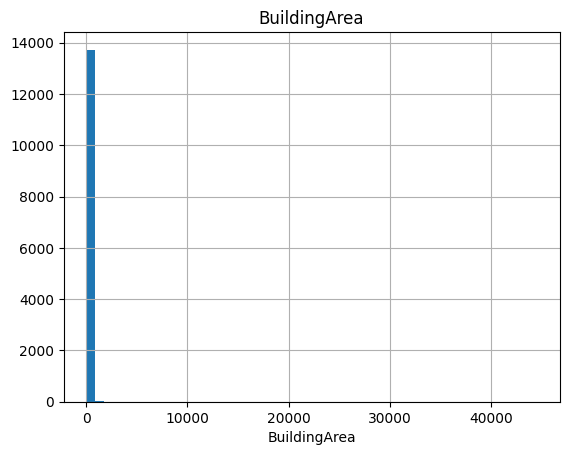

#####################################
count   15551.000
mean     1965.290
std        37.328
min      1196.000
5%       1900.000
10%      1910.000
20%      1930.000
30%      1950.000
40%      1960.000
50%      1970.000
60%      1980.000
70%      1993.000
80%      2003.000
90%      2010.000
95%      2013.000
99%      2016.000
max      2106.000
Name: YearBuilt, dtype: float64


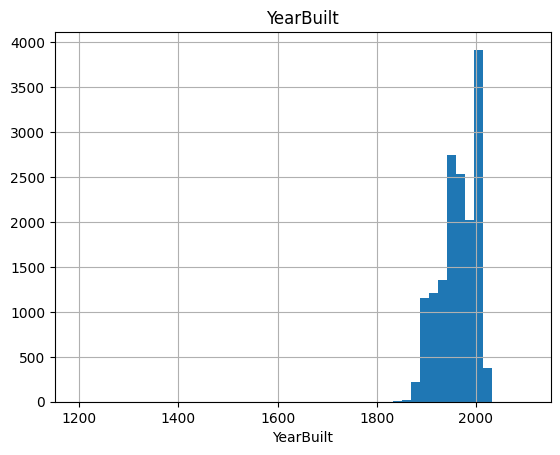

#####################################
count   34854.000
mean     7572.888
std      4428.090
min        83.000
5%       2185.000
10%      2674.000
20%      3650.000
30%      4836.000
40%      5556.000
50%      6763.000
60%      7809.000
70%      8989.000
80%     10969.000
90%     14577.000
95%     15510.000
99%     21650.000
max     21650.000
Name: Propertycount, dtype: float64


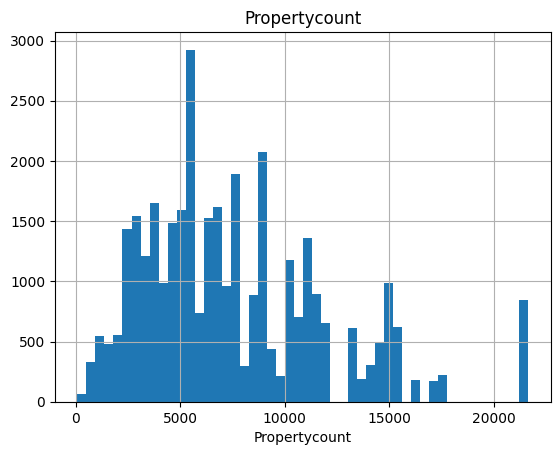

#####################################


In [9]:
######################################
# Sayısal Değişken Analizi (Analysis of Numerical Variables)
######################################

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

for col in num_cols:
    num_summary(df, col, True)

In [10]:
######################################
# Hedef Değişken Analizi (Analysis of Target Variable)
######################################

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df,"Price",col)


      TARGET_MEAN
Type             
h     1203718.500
t      931077.223
u      627943.422


        TARGET_MEAN
Method             
PI      1117883.994
PN              NaN
S       1051459.906
SA       982504.674
SN              NaN
SP       879022.365
SS              NaN
VB      1194205.291
W               NaN


                            TARGET_MEAN
Regionname                             
Eastern Metropolitan        1108723.002
Eastern Victoria             714328.205
Northern Metropolitan        861484.047
Northern Victoria            619051.205
South-Eastern Metropolitan   877682.680
Southern Metropolitan       1395928.334
Western Metropolitan         837615.322
Western Victoria             432606.771




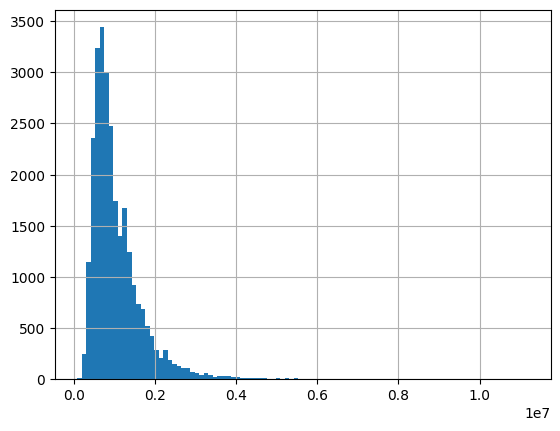

In [11]:
# Bağımlı değişkenin incelenmesi
df["Price"].hist(bins=100)
plt.show()

In [12]:
duplicates = df.duplicated()
df_no_duplicates = df[~duplicates]

# Print the number of duplicate rows
print("Number of duplicate rows:", duplicates.sum())

# Update the original DataFrame to contain only the non-duplicate data
df = df_no_duplicates

Number of duplicate rows: 1


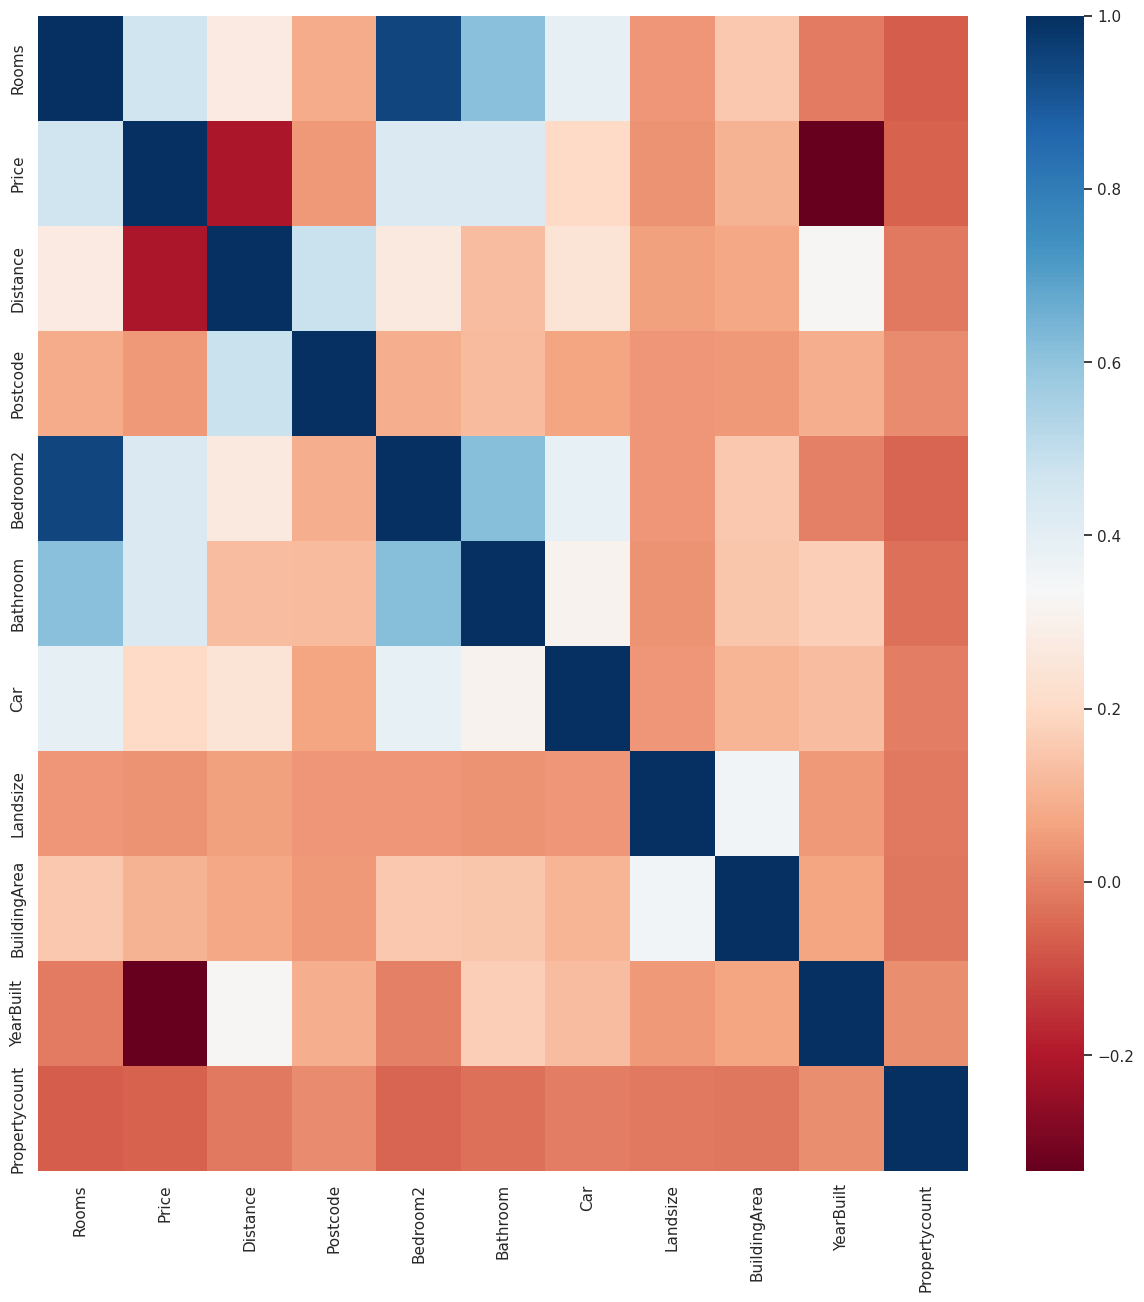

['Bedroom2']

In [13]:
def high_correlated_cols(df, col, plot=False, corr_th=0.70):
    corr = df[col].corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    
    if plot:
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
        
    return drop_list

high_correlated_cols(df, num_cols, plot=True)

In [14]:
######################################
# Aykırı Değer Analizi
######################################

# Aykırı değerlerin baskılanması
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    if col != "Price":
      print(col, check_outlier(df, col))


# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "Price":
        replace_with_thresholds(df,col)

Rooms True
Distance True
Postcode True
Bedroom2 True
Bathroom True
Car True
Landsize True
BuildingArea True
YearBuilt True
Propertycount False


In [15]:
######################################
# Eksik Değer Analizi
######################################

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

               n_miss  ratio
BuildingArea    21115 60.580
YearBuilt       19306 55.390
Landsize        11810 33.880
Car              8728 25.040
Bathroom         8226 23.600
Bedroom2         8217 23.570
Price            7609 21.830
CouncilArea         3  0.010
Regionname          3  0.010
Propertycount       3  0.010
Distance            1  0.000
Postcode            1  0.000


In [16]:
# Bazı değişkenlerdeki boş değerler evin o özelliğe sahip olmadığını ifade etmektedir
no_cols=["Bedroom2"]
# Kolonlardaki boşlukların "No" ifadesi ile doldurulması
for col in no_cols:
    df[col].fillna(False,inplace=True)
    
missing_values_table(df)

               n_miss  ratio
BuildingArea    21115 60.580
YearBuilt       19306 55.390
Landsize        11810 33.880
Car              8728 25.040
Bathroom         8226 23.600
Price            7609 21.830
CouncilArea         3  0.010
Regionname          3  0.010
Propertycount       3  0.010
Distance            1  0.000
Postcode            1  0.000


In [17]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="Price"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

df = quick_missing_imp(df, num_method="median", cat_length=17)

# BEFORE
Price             7609
Distance             1
Postcode             1
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Regionname           3
Propertycount        3
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

Price            7609
Distance            0
Postcode            0
Bathroom            0
Car                 0
Landsize            0
BuildingArea        0
YearBuilt           0
CouncilArea         3
Regionname          0
Propertycount       0
dtype: int64 




In [18]:
# Kategorik kolonların dağılımının incelenmesi

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "Price", cat_cols)

Type : 3
      COUNT  RATIO  TARGET_MEAN
Type                           
h     23980  0.688  1203718.500
t      3579  0.103   931077.223
u      7297  0.209   627943.422


Method : 9
        COUNT  RATIO  TARGET_MEAN
Method                           
PI       4850  0.139  1117883.994
PN        308  0.009          NaN
S       19744  0.566  1051459.906
SA        226  0.006   982504.674
SN       1317  0.038          NaN
SP       5094  0.146   879022.365
SS         36  0.001          NaN
VB       3108  0.089  1194205.291
W         173  0.005          NaN


Regionname : 8
                            COUNT  RATIO  TARGET_MEAN
Regionname                                           
Eastern Metropolitan         4376  0.126  1108723.002
Eastern Victoria              228  0.007   714328.205
Northern Metropolitan        9557  0.274   861484.047
Northern Victoria             203  0.006   619051.205
South-Eastern Metropolitan   1739  0.050   877682.680
Southern Metropolitan       11839  0.340  1395689

In [19]:
df["Type"] = np.where(df.Type.isin(["u", "t"]), "ut", df["Type"])
df["Regionname"] = np.where(df.Regionname.isin(["Northern Metropolitan", "Northern Victoria"]), "Northern", df["Regionname"])
df["Regionname"] = np.where(df.Regionname.isin(["Eastern Metropolitan", "Eastern Victoria"]), "Eastern", df["Regionname"])
df["Regionname"] = np.where(df.Regionname.isin(["Western Metropolitan", "Western Victoria"]), "Western", df["Regionname"])
df["Regionname"] = np.where(df.Regionname.isin(["Southern Metropolitan"]), "Southern", df["Regionname"])
df["Regionname"] = np.where(df.Regionname.isin(["South-Eastern Metropolitan"]), "South-Eastern", df["Regionname"])

In [20]:
# Kategorik kolonların dağılımının incelenmesi

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "Price", cat_cols)

Type : 2
      COUNT  RATIO  TARGET_MEAN
Type                           
h     23980  0.688  1203718.500
ut    10876  0.312   726949.858


Method : 9
        COUNT  RATIO  TARGET_MEAN
Method                           
PI       4850  0.139  1117883.994
PN        308  0.009          NaN
S       19744  0.566  1051459.906
SA        226  0.006   982504.674
SN       1317  0.038          NaN
SP       5094  0.146   879022.365
SS         36  0.001          NaN
VB       3108  0.089  1194205.291
W         173  0.005          NaN


Regionname : 5
               COUNT  RATIO  TARGET_MEAN
Regionname                              
Eastern         4604  0.132  1089680.088
Northern        9760  0.280   856472.359
South-Eastern   1739  0.050   877682.680
Southern       11839  0.340  1395689.471
Western         6914  0.198   831037.616




In [21]:
######################################
# GÖREV 3 : Yeni değişkenler oluşturunuz ve oluşturduğunuz yeni değişkenlerin başına 'NEW' ekleyiniz.
######################################
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df["NEW_Date_Year"] = df['Date'].dt.year
df = df.drop("Date", axis=1)
df["NEW_Ratio_Area"] = df.Landsize / df.BuildingArea

df["NEW_House_Age"] = df.NEW_Date_Year - df.YearBuilt

#df.columns = df.columns.str.upper()

In [22]:
##################
#Label Encoding & One-Hot Encoding işlemlerinin uygulanması
##################
labelencoder = LabelEncoder()

def label_encoder(dataframe, binary_col):    
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

columns_to_encode = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Regionname', 'CouncilArea']
for col in columns_to_encode:
    df=label_encoder(df, col)

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [23]:
check_dataframe(df)

##################### Shape #####################
(34856, 31)
##################### Types #####################
Suburb              int64
Address             int64
Rooms               int64
Price             float64
SellerG             int64
Distance          float64
Postcode          float64
Bedroom2           object
Bathroom          float64
Car               float64
Landsize          float64
BuildingArea      float64
YearBuilt         float64
CouncilArea         int64
Propertycount     float64
NEW_Date_Year       int32
NEW_Ratio_Area    float64
NEW_House_Age     float64
Type_1               bool
Method_1             bool
Method_2             bool
Method_3             bool
Method_4             bool
Method_5             bool
Method_6             bool
Method_7             bool
Method_8             bool
Regionname_1         bool
Regionname_2         bool
Regionname_3         bool
Regionname_4         bool
dtype: object
##################### Head #####################
   Suburb  Address 

In [24]:
##################################
# Modeli kurma işlemini gerçekleştiriniz.
##################################

# Sonsuz değerleri NaN ile değiştirme
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN değerleri temizleme
df.dropna(inplace=True)

X = df.drop("Price", axis=1)
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [25]:
models = {
    'Lasso': Lasso(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(n_estimators = 20, learning_rate = 1, loss = 'exponential', random_state = 42)
}

In [26]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    mae = mean_absolute_error(y_test, predict)
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predict)
    
    print(f"##########{model_name}##########")
    print("Mean Absolute Error:  ",mae)
    print("Mean Seqaure Error:  ",mse)
    print("R Mean Seqaure Error:  ",rmse)
    print("R2:  ",r2)
    print("Model Skoru:  ",model.score(X_test,y_test))
    print("\n")

##########Lasso##########
Mean Absolute Error:   279620.7228368808
Mean Seqaure Error:   172067546632.93585
R Mean Seqaure Error:   414810.25377024594
R2:   0.5812965752026044
Model Skoru:   0.5812965752026044


##########LinearRegression##########
Mean Absolute Error:   279621.2128483796
Mean Seqaure Error:   172067518152.59613
R Mean Seqaure Error:   414810.21944088617
R2:   0.5812966445057124
Model Skoru:   0.5812966445057124


##########Ridge##########
Mean Absolute Error:   279616.78738006204
Mean Seqaure Error:   172069639124.20258
R Mean Seqaure Error:   414812.7759896054
R2:   0.581291483404198
Model Skoru:   0.581291483404198


##########ElasticNet##########
Mean Absolute Error:   297131.34163073334
Mean Seqaure Error:   204228343063.61377
R Mean Seqaure Error:   451916.3009492065
R2:   0.5030375666141762
Model Skoru:   0.5030375666141762


##########KNeighborsRegressor##########
Mean Absolute Error:   385205.00067676906
Mean Seqaure Error:   331495772347.6183
R Mean Seqaure E